# POC: HRDEM Mosaic Fetch

This notebook is a simple, explicit end-to-end test for HRDEM fetching:
1. Read bbox from `tests/data/2407_FHIMP_tile/lowres032.tif`.
2. Run a STAC query against the HRDEM mosaic collection.
3. Display what the STAC search returned.
4. Open the returned DTM asset with `rasterio` and plot a window over the low-res tile footprint.

## 01) Imports And Constants

Keep everything in-line and explicit so each step is easy to inspect.

In [1]:
# Standard library imports for inspection and pretty-printing output.
import inspect
from pprint import pprint

# Third-party imports used for this POC.
import contextily as cx
import matplotlib.pyplot as plt
import numpy as np
import pystac_client
import rasterio
from matplotlib.patches import Rectangle
from pystac_client import Client
from rasterio.transform import array_bounds
from rasterio.warp import transform_bounds
from rasterio.windows import from_bounds

In [2]:
# Print package versions directly from the active runtime.
print(f"numpy: {np.__version__}")
print(f"pystac_client: {getattr(pystac_client, '__version__', 'unknown')}")
print(f"rasterio: {rasterio.__version__}")
print(f"contextily: {cx.__version__}")

numpy: 2.4.2
pystac_client: 0.9.0
rasterio: 1.5.0
contextily: 1.7.0


In [3]:

# Local input raster that defines the AOI.
LOWRES_FP = "tests/data/2407_FHIMP_tile/lowres032.tif"

# STAC configuration from ADR-0010.
STAC_URL = "https://datacube.services.geo.ca/api"
COLLECTION = "hrdem-mosaic-1m"
DEFAULT_ASSET = "dtm"

print("Configured input and STAC constants.")
print(f"LOWRES_FP: {LOWRES_FP}")
print(f"STAC_URL: {STAC_URL}")
print(f"COLLECTION: {COLLECTION}")
print(f"DEFAULT_ASSET: {DEFAULT_ASSET}")

Configured input and STAC constants.
LOWRES_FP: tests/data/2407_FHIMP_tile/lowres032.tif
STAC_URL: https://datacube.services.geo.ca/api
COLLECTION: hrdem-mosaic-1m
DEFAULT_ASSET: dtm


## 02) Environment And API Surface Check

Print package versions and a couple signatures from the current environment so behavior is reproducible.

In [4]:
# Inspect a couple key call signatures from this environment.
print("\nKey API signatures from this runtime:")
print(f"Client.search: {inspect.signature(Client.search)}")
print(f"rasterio.open: {inspect.signature(rasterio.open)}")
print(f"from_bounds: {inspect.signature(from_bounds)}")
print(f"cx.add_basemap: {inspect.signature(cx.add_basemap)}")


Key API signatures from this runtime:
Client.search: (self, *, method: str | None = 'POST', max_items: int | None = None, limit: int | None = None, ids: Union[tuple[str, ...], str, list[str], collections.abc.Iterator[str], NoneType] = None, collections: Union[list[str], collections.abc.Iterator[str], str, NoneType] = None, bbox: Union[tuple[float, ...], list[float], collections.abc.Iterator[float], str, NoneType] = None, intersects: Union[str, pystac_client.item_search.GeoInterface, dict[str, Any], NoneType] = None, datetime: Union[datetime.datetime, str, NoneType, tuple[Union[datetime.datetime, str, NoneType], Union[datetime.datetime, str, NoneType]], list[Union[datetime.datetime, str, NoneType]], collections.abc.Iterator[Union[datetime.datetime, str, NoneType]]] = None, query: Union[dict[str, Any], list[str], NoneType] = None, filter: Union[dict[str, Any], str, NoneType] = None, filter_lang: str | None = None, sortby: Union[list[dict[str, str]], str, list[str], NoneType] = None, fie

## 03) Read Low-Res Raster And Build BBoxes

We keep both:
- native bbox in the raster CRS (for raster windowing),
- EPSG:4326 bbox (for STAC query).

In [5]:
# Open the low-resolution raster and extract metadata/bounds.
with rasterio.open(LOWRES_FP) as lowres_ds:
    lowres_crs = lowres_ds.crs
    lowres_bounds = tuple(lowres_ds.bounds)
    lowres_shape = (lowres_ds.height, lowres_ds.width)
    lowres_res = lowres_ds.res

# Convert native bounds to EPSG:4326 for STAC.
lowres_bbox_4326 = transform_bounds(
    lowres_crs,
    "EPSG:4326",
    *lowres_bounds,
    densify_pts=21,
)

# Basic sanity checks right after loading inputs.
assert lowres_crs is not None, "Expected low-res raster CRS to exist."
assert len(lowres_bounds) == 4, "Expected 4-value bounds tuple."
assert lowres_bbox_4326[0] < lowres_bbox_4326[2], "Invalid bbox x ordering."
assert lowres_bbox_4326[1] < lowres_bbox_4326[3], "Invalid bbox y ordering."

print("Low-res raster details:")
print(f"  CRS: {lowres_crs}")
print(f"  Bounds ({lowres_crs}): {lowres_bounds}")
print(f"  Shape (rows, cols): {lowres_shape}")
print(f"  Resolution: {lowres_res}")
print("\nSTAC query bbox (EPSG:4326):")
print(f"  {lowres_bbox_4326}")

Low-res raster details:
  CRS: EPSG:3979
  Bounds (EPSG:3979): (-1300733.0767616061, 429695.82318666467, -1299709.0767616061, 430719.82318666467)
  Shape (rows, cols): (32, 32)
  Resolution: (32.0, 32.0)

STAC query bbox (EPSG:4326):
  (-114.0030011757223, 51.111831026745314, -113.98458029791806, 51.123424953619406)


### plot the search bbox

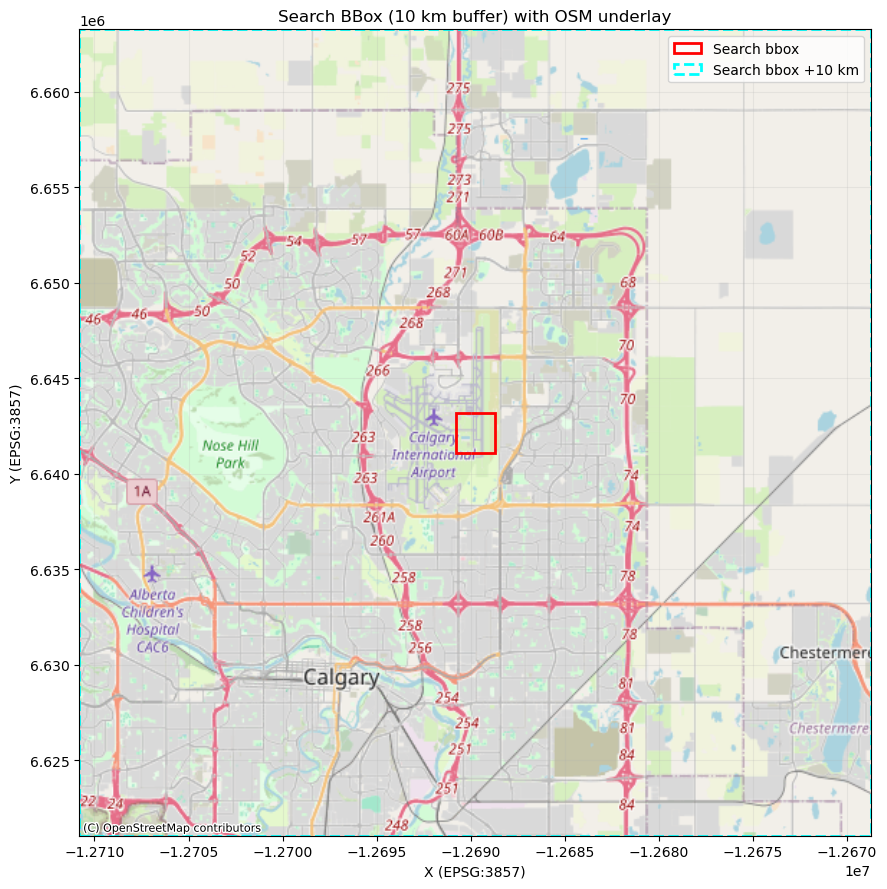

Search bbox (native CRS): (-1300733.0767616061, 429695.82318666467, -1299709.0767616061, 430719.82318666467)
Buffered bbox (native CRS): (-1310733.0767616061, 419695.82318666467, -1289709.0767616061, 440719.82318666467)
Search bbox (EPSG:3857): (-12690756.039786374, 6641099.227323835, -12688705.43704924, 6643155.275667902)
Buffered bbox (EPSG:3857): (-12710814.491845539, 6621043.009488969, -12668713.07415534, 6663256.271579655)


In [6]:
# Plot the search bbox with a 10 km buffer on an OSM basemap.
# We keep this fully in-line and explicit so every transformation is easy to inspect.

# Unpack native raster bounds from the low-res tile CRS.
left, bottom, right, top = lowres_bounds

# Define a simple 10 km buffer in native CRS units (meters for EPSG:3979).
buffer_m = 10_000
buffered_bounds = (
    left - buffer_m,
    bottom - buffer_m,
    right + buffer_m,
    top + buffer_m,
)

# Convert both bounds to Web Mercator (EPSG:3857) for OSM plotting via contextily.
bbox_3857 = transform_bounds(lowres_crs, "EPSG:3857", *lowres_bounds, densify_pts=21)
buffered_bbox_3857 = transform_bounds(lowres_crs, "EPSG:3857", *buffered_bounds, densify_pts=21)

# Sanity checks to catch malformed bounds before plotting.
assert bbox_3857[0] < bbox_3857[2], "Invalid transformed bbox x ordering."
assert bbox_3857[1] < bbox_3857[3], "Invalid transformed bbox y ordering."
assert buffered_bbox_3857[0] < buffered_bbox_3857[2], "Invalid transformed buffered bbox x ordering."
assert buffered_bbox_3857[1] < buffered_bbox_3857[3], "Invalid transformed buffered bbox y ordering."

# Build figure and axis.
fig, ax = plt.subplots(figsize=(9, 9))

# Set extent to the buffered bbox first so contextily fetches tiles for the full area.
ax.set_xlim(buffered_bbox_3857[0], buffered_bbox_3857[2])
ax.set_ylim(buffered_bbox_3857[1], buffered_bbox_3857[3])

# Add OSM underlay.
cx.add_basemap(
    ax,
    source=cx.providers.OpenStreetMap.Mapnik,
    crs="EPSG:3857",
)

# Draw the exact search bbox in red.
search_box = Rectangle(
    (bbox_3857[0], bbox_3857[1]),
    bbox_3857[2] - bbox_3857[0],
    bbox_3857[3] - bbox_3857[1],
    fill=False,
    edgecolor="red",
    linewidth=2,
    label="Search bbox",
)
ax.add_patch(search_box)

# Draw the 10 km buffered bbox in cyan dashed style.
buffer_box = Rectangle(
    (buffered_bbox_3857[0], buffered_bbox_3857[1]),
    buffered_bbox_3857[2] - buffered_bbox_3857[0],
    buffered_bbox_3857[3] - buffered_bbox_3857[1],
    fill=False,
    edgecolor="cyan",
    linewidth=2,
    linestyle="--",
    label="Search bbox +10 km",
)
ax.add_patch(buffer_box)

# Annotate and format plot.
ax.set_title("Search BBox (10 km buffer) with OSM underlay")
ax.set_xlabel("X (EPSG:3857)")
ax.set_ylabel("Y (EPSG:3857)")
ax.legend(loc="upper right")
ax.grid(alpha=0.2)

plt.tight_layout()
plt.show()

# Print bounds so they are visible in notebook outputs.
print("Search bbox (native CRS):", lowres_bounds)
print("Buffered bbox (native CRS):", buffered_bounds)
print("Search bbox (EPSG:3857):", bbox_3857)
print("Buffered bbox (EPSG:3857):", buffered_bbox_3857)

## 04) Run STAC Query

Query the HRDEM mosaic collection using the bbox from the low-res raster.

In [7]:
# Open STAC client and run search.
client = Client.open(STAC_URL)
search = client.search(
    collections=[COLLECTION],
    bbox=list(lowres_bbox_4326),
    limit=10,
)
items = list(search.items())

# We expect at least one intersecting HRDEM item.
assert len(items) > 0, "No STAC items returned for the low-res raster bbox."

print(f"Returned {len(items)} STAC item(s).")
for idx, item in enumerate(items, start=1):
    print(f"  {idx}. id={item.id} | assets={len(item.assets)}")

Returned 1 STAC item(s).
  1. id=3_3-mosaic-1m | assets=9


## 05) Display STAC Return

Show a concise but informative view of the first returned item and its assets.

In [8]:
# Inspect the first item in detail.
item = items[0]

print("First item summary:")
print(f"  id: {item.id}")
print(f"  datetime: {item.datetime}")
print(f"  geometry type: {item.geometry.get('type') if item.geometry else None}")
print(f"  bbox: {item.bbox}")
print("\nAsset keys:")
print(sorted(item.assets.keys()))

print("\nSelected asset metadata (dtm):")
assert DEFAULT_ASSET in item.assets, f"Expected asset '{DEFAULT_ASSET}' in first item."
asset = item.assets[DEFAULT_ASSET]
asset_overview = {
    "title": asset.title,
    "media_type": asset.media_type,
    "roles": asset.roles,
    "href": asset.href,
}
pprint(asset_overview)

asset_href = asset.href
print("\nAsset href selected for raster read:")
print(asset_href)

First item summary:
  id: 3_3-mosaic-1m
  datetime: 2023-07-12 12:00:00+00:00
  geometry type: Polygon
  bbox: [-117.040404, 46.88878, -108.461815, 52.449359]

Asset keys:
['coverage', 'dsm', 'dsm-vrt', 'dtm', 'dtm-vrt', 'extent', 'hillshade-dsm', 'hillshade-dtm', 'thumbnail']

Selected asset metadata (dtm):
{'href': 'https://canelevation-dem.s3.ca-central-1.amazonaws.com/hrdem-mosaic-1m/3_3-mosaic-1m-dtm.tif',
 'media_type': 'image/tiff; application=geotiff; profile=cloud-optimized',
 'roles': ['data'],
 'title': 'Digital Terrain Model (COG)'}

Asset href selected for raster read:
https://canelevation-dem.s3.ca-central-1.amazonaws.com/hrdem-mosaic-1m/3_3-mosaic-1m-dtm.tif


## 06) Read HRDEM Asset Window With Rasterio

Read only the window overlapping the low-res raster bounds (not the full mosaic).

In [9]:
# Open remote HRDEM raster and read the AOI window.
with rasterio.open(asset_href) as hrdem_ds:
    hrdem_crs = hrdem_ds.crs
    hrdem_shape = (hrdem_ds.height, hrdem_ds.width)
    hrdem_res = hrdem_ds.res
    hrdem_nodata = hrdem_ds.nodata

    # Transform low-res bounds into the HRDEM CRS when needed.
    if hrdem_crs != lowres_crs:
        query_bounds_hrdem = transform_bounds(
            lowres_crs,
            hrdem_crs,
            *lowres_bounds,
            densify_pts=21,
        )
    else:
        query_bounds_hrdem = lowres_bounds

    # Build a raster window from the projected bounds.
    window = from_bounds(*query_bounds_hrdem, transform=hrdem_ds.transform)
    window = window.round_offsets().round_lengths()

    # Read a single-band elevation array as masked data.
    dem_window = hrdem_ds.read(1, window=window, masked=True)
    dem_transform = hrdem_ds.window_transform(window)

# Validate that we read meaningful data.
assert dem_window.size > 0, "DEM window read returned empty array."
assert dem_window.shape[0] > 0 and dem_window.shape[1] > 0, "DEM window has invalid shape."

print("HRDEM source details:")
print(f"  CRS: {hrdem_crs}")
print(f"  Shape (rows, cols): {hrdem_shape}")
print(f"  Resolution: {hrdem_res}")
print(f"  Nodata: {hrdem_nodata}")
print("\nRead window details:")
print(f"  Window: {window}")
print(f"  Window shape: {dem_window.shape}")
print(f"  Min elevation: {float(np.nanmin(dem_window)):.3f}")
print(f"  Max elevation: {float(np.nanmax(dem_window)):.3f}")

HRDEM source details:
  CRS: EPSG:3979
  Shape (rows, cols): (500000, 500000)
  Resolution: (1.0, 1.0)
  Nodata: -32767.0

Read window details:
  Window: Window(col_off=199267, row_off=69280, width=1024, height=1024)
  Window shape: (1024, 1024)
  Min elevation: 1073.676
  Max elevation: 1092.578


## 07) Plot The Returned HRDEM Data

Plot the fetched elevation window with map coordinates in the HRDEM CRS.

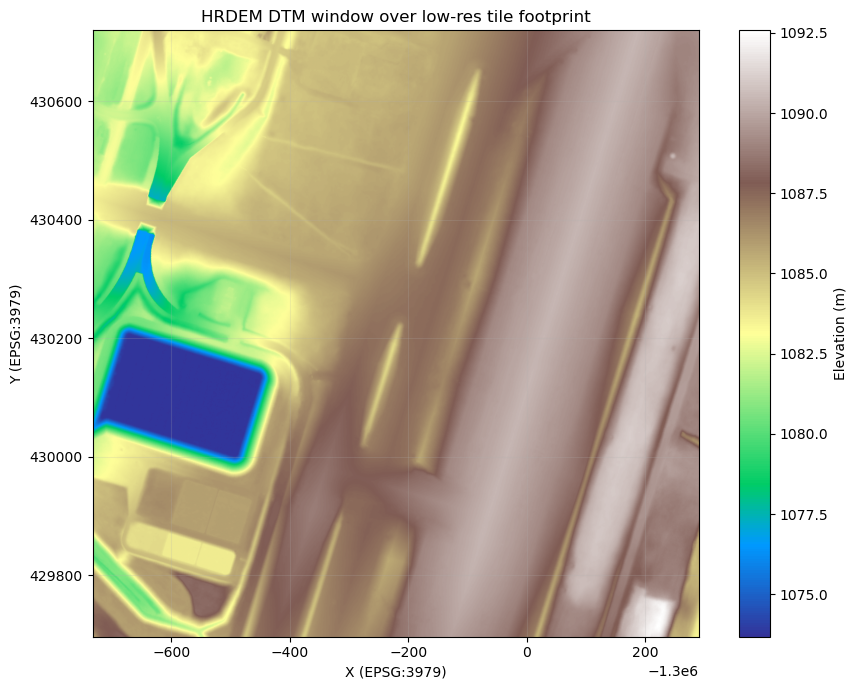

In [10]:
# Compute plotting extent from the window transform.
# array_bounds returns (west, south, east, north).
west, south, east, north = array_bounds(
    dem_window.shape[0],
    dem_window.shape[1],
    dem_transform,
)
plot_extent = [west, east, south, north]

# Create a basic elevation plot.
fig, ax = plt.subplots(figsize=(9, 7))
img = ax.imshow(dem_window, extent=plot_extent, cmap="terrain")
ax.set_title("HRDEM DTM window over low-res tile footprint")
ax.set_xlabel(f"X ({hrdem_crs})")
ax.set_ylabel(f"Y ({hrdem_crs})")
ax.grid(alpha=0.2)

cbar = fig.colorbar(img, ax=ax)
cbar.set_label("Elevation (m)")

plt.tight_layout()
plt.show()

## 08) Quick Result Summary

If you reached this cell successfully, the full fetch test worked:
- bbox extracted from local tile,
- STAC query returned items,
- DTM asset opened remotely,
- raster window read and plotted.